# Basic Timing Evaluation
The following notebook demonstrates a workflow which evaluates the timing of a single single simulation run. The notebook directly accesses several Python classes and definitions which were provided by [FMITerminalBlock](https://github.com/AIT-IES/FMITerminalBlock) to process timing files. The main FMITerminalBlock executable may be configured to output these timing files in order to assess the real time performance of a simulation run.
The project specific python code is located in the ```timing``` package. The ```timing.data_set``` module defines a ```DataSet``` class and several utility classes which hold the timing data in the memory and provide some evaluation functions. Please consider the source code documentation for a more detailed description of accessed functions.

In [1]:
from timing import data_set as tds

## Load the Timing File
Timing files may be loaded via the convenience function ```tds.load_data_set_from_file(filename)```. The function constructs all facilities which are necessary to parse the timing file and to instantiate a ```tds.DataSet``` object. Please adjust the filename variable such that it points to the timing file which should be analyzed.

In [2]:
timing_file_path = r"S:\output-data\timing.csv" # <-- Adjust your path here
ds = tds.load_data_set_from_file(timing_file_path)

## Query Performance Indicators
FMITerminalBlock records the current real time instant and the current simulation time at various points during simulation. For instance, it is recorded when FMITerminalBlock predicts the next event and when the event is actually distributed to connected devices. In particular, the following time stamps are recorded:
* Registration time of events. The registration is the point in time where an event is predicted by the solver or sent to FMITerminalBlock by an external entity.
* Begin of distribution. During distribution the event is sent to all network devices and will be deleted afterwards
* End of distribution.

These numbers will be used to calculate certain performance metrics. During standard real time operation, FMITerminalBlock should start the distribution when the simulation time is reached in real time. The delay of predicted events at the begin of the distribution phase indicates that FMITerminalBlock is not able to complete all necessary operations before the event should be scheduled.

Since many metrics such as average delay can be applied to many processing stages and subsets of the timing data, ```tds.TimingAxis``` class was created. Any instance of ```tds.TimingAxis``` allows to query certain performance metrics for a subset of the timing data. ```tds.DataSet``` offers several functions which expose various ```tds.TimingAxis``` objects. The following sections will demonstrate most of the timing axis and performance indicators

### Direct Query
In order to query parameters regarding one axis (e.g. the registration time), the appropriate ```tds.TimingAxis``` object has to be queried.

In [3]:
registration_axis = ds.get_registration_axis()

The axis object may then be used to calculate certain timing statistics. For instance, use ```get_mean_delay()```, ```get_min_delay()```, ```get_max_delay()``` to query the mean, average, and maximum delay respectively. The variance of delay values may be obtained via ```get_variance_of_delay()```. Pleas note that per default the function also include early events. For instance predicted events are normally registered earlier than their associated time. Hence, their delay will be negative which also affects the statistical values. Additionally, the number of elements which are covered by a particular axis may be queried by ```get_length()```.

In [4]:
print("Number of registered timing samples: ", registration_axis.get_length())
print("Minimum delay:     ", registration_axis.get_min_delay())
print("Maximum delay:     ", registration_axis.get_max_delay())
print("Average delay:     ", registration_axis.get_mean_delay())
print("Variance in delay: ", registration_axis.get_variance_of_delay())

Number of registered timing samples:  233
Minimum delay:      -0.04195
Maximum delay:      0.29905
Average delay:      0.00689463519313
Variance in delay:  0.00443755683532


### Supported Axis

The following timing axes are supported. Each of the axis may be queried by the given function from any DataSource object. 
* ```get_registration_axis()```
* ```get_begin_distribution_axis()```
* ```get_end_distribution_axis()```

### Removal of Outliers 

The evaluation scripts support a basic mechanism which removes outliers. An outlier is a value with an exceptionally high or low delay value. Each timing axis object provides a function, ```get_delay_cleaned_axis()``` which removes the samples with the highest and lowest delay values and returns a newly constructed timing axis. The optional parameter ```outlier_factor``` specifies the share of removed samples. Per default 5% of the samples are removed. Please note that outliers are always removed symmetrically from the highest and lowest part of the delay spectrum.

In [5]:
clean_registration_axis = registration_axis.get_delay_cleaned_axis(outlier_factor=0.1)
print(clean_registration_axis.get_length(), " of ", registration_axis.get_length(), " samples left")

211  of  233  samples left


Satistics of each cleaned axis may be obtained as usual.

In [6]:
print("Number of registered timing samples: ", clean_registration_axis.get_length())
print("Minimum delay:     ", clean_registration_axis.get_min_delay())
print("Maximum delay:     ", clean_registration_axis.get_max_delay())
print("Average delay:     ", clean_registration_axis.get_mean_delay())
print("Variance in delay: ", clean_registration_axis.get_variance_of_delay())

Number of registered timing samples:  211
Minimum delay:      -0.02795
Maximum delay:      0.18505
Average delay:      -0.00326374407583
Variance in delay:  0.0017884478102


### Formated Timing Parameters
A pre-formated version of all timing parameters may be obtained via the ```to_html_statistics()``` function of the ```timing.display``` module. Hence, the module first has to be loaded. Additional imoprts are required to print the output via Jupyther.

In [7]:
from timing import display as disp
from IPython.display import display, HTML

Afterwards, the statistics may be printed as follows.

In [8]:
html = HTML(disp.to_html_statistics(ds))
display(html)

Axis,Samples,Mean Delay,Delay Variance,Min. Delay,Max. Delay
Registration,233,0.006895,0.0044,-0.0419,0.2991
Registration (Cleaned),223,0.001735,0.0029,-0.0299,0.2331
Begin Distribution,229,0.03766,0.0042,0.0010,0.3310
Begin Distribution (Cleaned),219,0.03236,0.0027,0.0100,0.2751
End Distribution,229,0.04027,0.0042,0.0040,0.3320
End Distribution (Cleaned),219,0.03495,0.0027,0.0120,0.2771


## Graphical Output of Delays

Sometimes it is appropriate to print the delay values over time. Each axis therefore provides a ```get_raw_data()``` function which returns a numpy array. The first column will be set to the simulation timestamps and the second one to the real-time stamps. Whenever only one column is needed, ```get_simulation_time_data()``` returns a vector of simulation time stamps and ```get_real_time_data()``` returns a vector of real-time stamps only. Similarly the function ```get_delay()``` returns the time series of delay values. Each row in the delay values vector corresponds to the row in the other data vectors.

In [9]:
clean_reg_axis = ds.get_registration_axis().get_delay_cleaned_axis()
clean_begin_dist_axis = ds.get_begin_distribution_axis().get_delay_cleaned_axis()
clean_end_dist_axis = ds.get_end_distribution_axis().get_delay_cleaned_axis()

The raw data may be plotted, for instance, via matplotlib.

In [10]:
import matplotlib.pyplot as plt

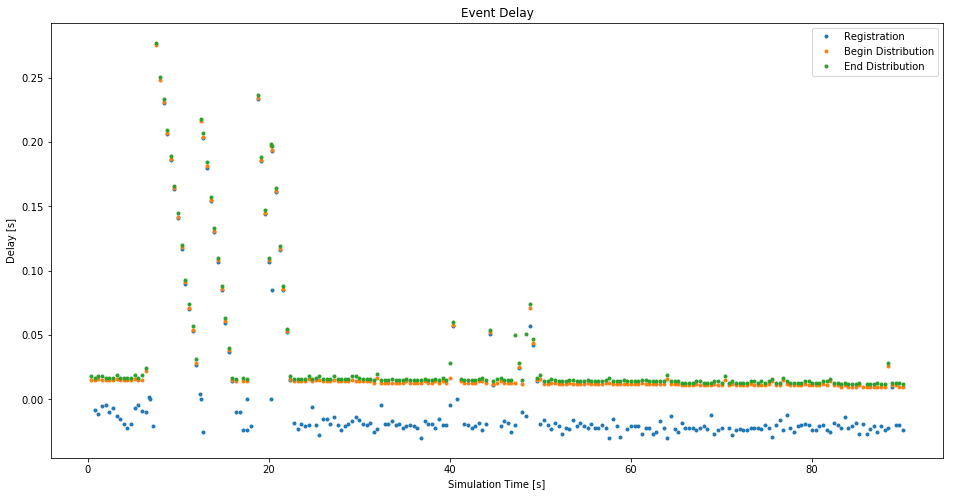

In [11]:
plt.figure(figsize=(16,8), dpi=72)

# Plot the sime series data of all cleaned axis
plt.plot(clean_reg_axis.get_simulation_time_data(), clean_reg_axis.get_delay(), '.', label="Registration")
plt.plot(clean_begin_dist_axis.get_simulation_time_data(), clean_begin_dist_axis.get_delay(), '.', label="Begin Distribution")
plt.plot(clean_end_dist_axis.get_simulation_time_data(), clean_end_dist_axis.get_delay(), '.', label="End Distribution")

plt.ylabel("Delay [s]")
plt.xlabel("Simulation Time [s]")
plt.title("Event Delay")
plt.legend()
plt.show()

## Delay Distribution
The raw and delay values may also be directly used to generate a histogram.

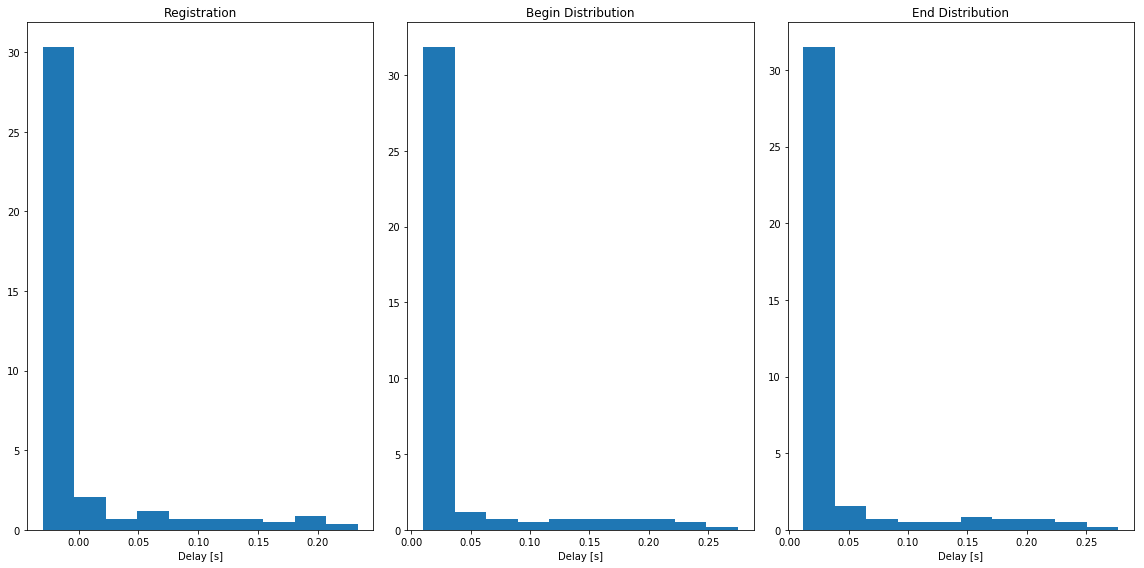

In [12]:
plt.figure(figsize=(16,8), dpi=72)

plt.subplot(1,3,1)
plt.hist(clean_reg_axis.get_delay(), normed=True)
plt.title("Registration")
plt.xlabel("Delay [s]")

plt.subplot(1,3,2)
plt.hist(clean_begin_dist_axis.get_delay(), normed=True)
plt.title("Begin Distribution")
plt.xlabel("Delay [s]")

plt.subplot(1,3,3)
plt.hist(clean_end_dist_axis.get_delay(), normed=True)
plt.title("End Distribution")
plt.xlabel("Delay [s]")

plt.tight_layout()
plt.show()